# Reprogramming Imagenet to CIFAR10


In [0]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

#import cnn_utils as utils
#from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.engine import Model
from keras.applications import VGG16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Using TensorFlow backend.


## Load and Prepare DataSet

In [0]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 0.0001
MOMENTUM = 0.9

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


Split training dataset in train and validation sets

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

Transform target variable/labels into one hot encoded form

In [0]:
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

### Preprocessing

Since we are about to use VGG16 as a feature extractor, the minimum size of an image it takes is 48x48.
We utilize ```skimage`` to resize images to required dimensions

In [0]:
from skimage.transform import resize
X_train = np.array([resize(x,(48, 48)) for x in X_train])
X_val = np.array([resize(x,(48, 48)) for x in X_val])
X_test = np.array([resize(x,(48, 48)) for x in X_test])

## Prepare the Model

* Load VGG16 without the top classification layer
* Prepare a custom classifier
* Stack both models on top of each other

In [8]:
base_model = vgg(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3), classes=10)

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [0]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [11]:
# Add classification layers on top of it

x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Since our objective reprogramming without changing target model parameters, we freeze the layers of VGG16

In [0]:
for layer in base_model.layers:
     layer.trainable = False

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [15]:
model.layers[0].trainable = False

for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f86048ca630> False
<keras.layers.convolutional.Conv2D object at 0x7f85c1ca20f0> False
<keras.layers.convolutional.Conv2D object at 0x7f85c1f0d208> False
<keras.layers.pooling.MaxPooling2D object at 0x7f85bf5fe438> False
<keras.layers.convolutional.Conv2D object at 0x7f85bca87978> False
<keras.layers.convolutional.Conv2D object at 0x7f85bca8cb70> False
<keras.layers.pooling.MaxPooling2D object at 0x7f85bca949e8> False
<keras.layers.convolutional.Conv2D object at 0x7f85bcaa12e8> False
<keras.layers.convolutional.Conv2D object at 0x7f85bcaa1e10> False
<keras.layers.convolutional.Conv2D object at 0x7f85bcaaf048> False
<keras.layers.pooling.MaxPooling2D object at 0x7f85bcab48d0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f85bcd8fdd8> True
<keras.layers.normalization.BatchNormalization object at 0x7f85bcdb5358> True
<keras.layers.core.Dense object at 0x7f860512df60> True
<keras.layers.core.Dense object at 0x7f85b00fa240> 

## Data Augmentation

To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using 
```keras ``` utilities

In [0]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [0]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [0]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

## Train the Model

In [19]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
1328/1328 [==============================] - 11s 8ms/step - loss: 1.9690 - acc: 0.2940 - val_loss: 1.6654 - val_acc: 0.4251
Epoch 2/40
1328/1328 [==============================] - 10s 8ms/step - loss: 1.6637 - acc: 0.4059 - val_loss: 1.4954 - val_acc: 0.4830
Epoch 3/40
1328/1328 [==============================] - 10s 7ms/step - loss: 1.5430 - acc: 0.4489 - val_loss: 1.3923 - val_acc: 0.5098
Epoch 4/40
1328/1328 [==============================] - 10s 7ms/step - loss: 1.4614 - acc: 0.4793 - val_loss: 1.3287 - val_acc: 0.5266
Epoch 5/40
1328/1328 [==============================] - 10s 7ms/step - loss: 1.4053 - acc: 0.5000 - val_loss: 1.2749 - val_acc: 0.5505
Epoch 6/40
1328/1328 [==============================] - 10s 7ms/step - loss: 1.3653 - acc: 0.5163 - val_loss: 1.2383 - val_acc: 0.5592
Epoch 7/40
1328/1328 [==============================] - 10s 8ms/step - loss: 1.3188 - acc: 0.5

## Analyze Model Performance

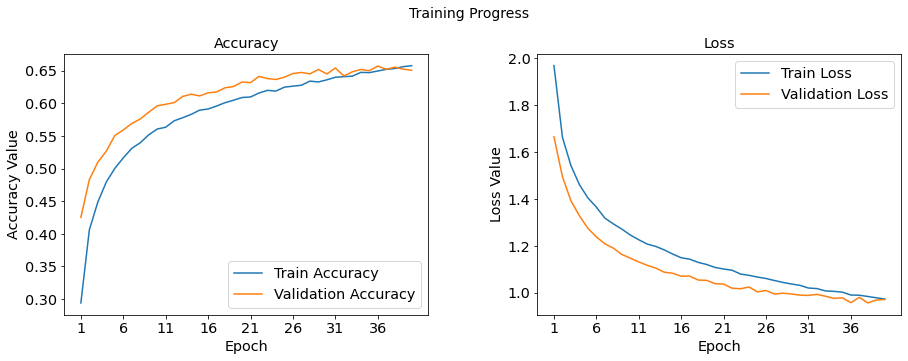

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Training Progress', fontsize=14)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs[::5])
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs[::5])
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
predictions = model.predict(X_test/255.)

In [0]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [23]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [24]:
train_accuracy = history.history['acc'][-1]
print('Train accuracy:', train_accuracy)


test_accuracy = history.history['val_acc'][-1]
print('Test accuracy:', test_accuracy)



Train accuracy: 0.6575774700951305
Test accuracy: 0.6505088377394775


Confusion matrix, without normalization


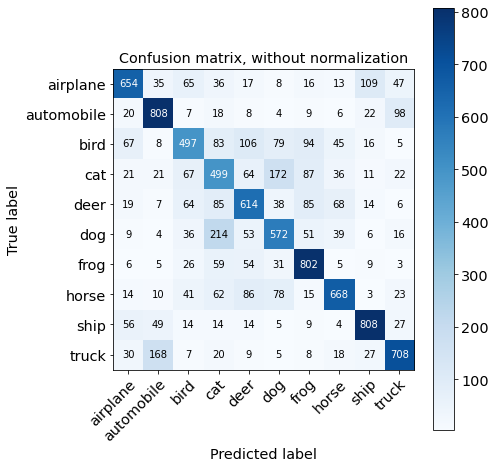

In [25]:
#Compute the confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



confusion_mtx=confusion_matrix(test_labels,predictions)
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Plot non-normalized confusion matrix
plot_confusion_matrix(test_labels, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


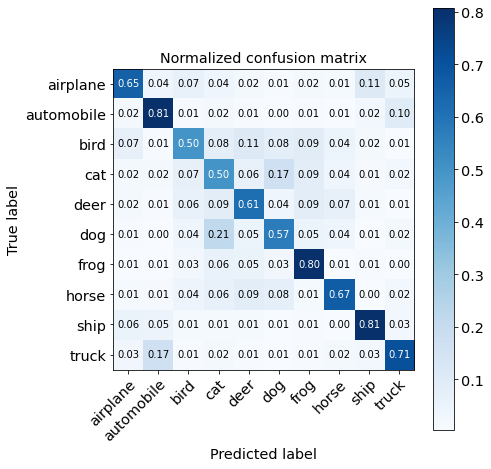

In [26]:


# Plot normalized confusion matrix
plot_confusion_matrix(test_labels, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')